# Checking Environment

pygame 2.4.0 (SDL 2.26.4, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


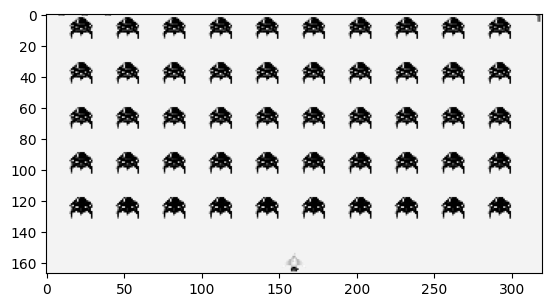

In [1]:
from utils import make_env

from matplotlib import pyplot as plt


env = make_env(num_stack=None)
obs = env.reset()

action = env.action_space.sample()
obs, *_ = env.step(action)

plt.imshow(obs, cmap="gray")
plt.show()

env.close()
del env

# Configuring Requirements

In [2]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv


vec_env = make_vec_env(lambda: MaxAndSkipEnv(make_env(num_stack=None, truncate_on_shiphit=True), 4), n_envs=100) # vec_env_cls=SubprocVecEnv 

In [3]:
from stable_baselines3.common.callbacks import BaseCallback

from utils import save_frames_to_gif

import numpy as np

import os


class SaveBestCallback(BaseCallback):

    def __init__(self, save_path_postfix, verbose=0):
        super(SaveBestCallback, self).__init__(verbose)

        self.save_path_postfix = save_path_postfix
        self.model_path = os.path.join("models/stablebaselines/logs", save_path_postfix)
        os.makedirs(self.model_path, exist_ok=True)

        self.best_score = float("-inf")

    def _on_step(self):
        pass

    def _on_rollout_start(self):
        env = make_env(num_stack=None, truncate_on_shiphit=True)

        state = env.reset()
        rewards = 0
        done = False
        _states = None
        episode_starts = np.ones((1,), dtype=bool)

        frames = []
        while not done:
            action, _states = self.model.predict(state, state=_states, episode_start=episode_starts, deterministic=True)
            state, reward, done, info = env.step(action)
            episode_starts = done
            rewards += reward

            obs = env.render(mode="rgb_array")
            frames.append(obs)

        print(f"Iteration#{self.n_calls//self.model.n_steps}, Rewards: {rewards}")

        # env.close()
        # del env

        if rewards > self.best_score:
            print(f"Found new best model with Rewards: {rewards}")
            self.best_score = rewards

            print("Saving new best model.")
            self.model.save(self.model_path+f"/best_model_#step{self.num_timesteps}_#rwd{rewards}.zip")

            print("Saving new best model's gif.")
            save_frames_to_gif(frames, f"logs/{self.save_path_postfix}/alieninvasion_recurrent_ppo_stablebaselines_#step{self.num_timesteps}_#rwd{rewards}.gif", frames_step=10)

In [4]:
from stable_baselines3.common.callbacks import CheckpointCallback


checkpoint_callback = CheckpointCallback(
  save_freq=128*10, 
  save_path="models/stablebaselines/logs/1",
  verbose=2
)

# Training Agent

In [5]:
from sb3_contrib import RecurrentPPO


n_steps = 10_000_000
model = RecurrentPPO("CnnLstmPolicy", vec_env, verbose=1, tensorboard_log=f"logs/{n_steps: _}") # , ent_coef=0.001

model.learn(total_timesteps=n_steps, log_interval=1, callback=checkpoint_callback) # , SaveBestCallback("1/best")

model.save("models/stablebaselines/Alien Invasion PPO+RNN test6")

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to logs/ 10_000_000\RecurrentPPO_55
Saving model checkpoint to models/stablebaselines/logs/1\rl_model_128000_steps.zip
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 419         |
|    ep_rew_mean          | 4.92        |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 10          |
|    time_elapsed         | 1871        |
|    total_timesteps      | 128000      |
| train/                  |             |
|    approx_kl            | 0.020066204 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.515       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0242     |
|    value_loss 

In [6]:
vec_env.close()
del vec_env

# Running The Agent

In [9]:
import numpy as np

import time


# model = RecurrentPPO.load("models/stablebaselines/logs/2/rl_model_73600_steps.zip")

env = make_env(num_stack=None)

state = env.reset()
rewards = 0
done = False
_states = None
episode_starts = np.ones((1,), dtype=bool)

frames = []
start = time.time()
while not done:
    action, _states = model.predict(state, state=_states, episode_start=episode_starts, deterministic=True)
    state, reward, done, info = env.step(action)
    episode_starts = done

    rewards += reward
    print("\r{}, {}".format(rewards, reward), end="")

    obs = env.render(mode="rgb_array")
    frames.append(obs)

fps = len(frames) // (time.time() - start)
print(f"\nFPS: {fps}, Frames: {len(frames)}")

179, -10
FPS: 0.0, Frames: 0


In [ ]:
save_frames_to_gif(frames, f"alieninvasion_recurrent_ppo_test_stablebaselines_{n_steps}_steps.gif")